In [1]:
import os
import sys

In [2]:
import sqlite3 as db

In [46]:
# import swifter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.3f}'.format # float precisions

In [27]:
con = db.connect(r"C:\Users\debmalya\pOrgz\database.db")

In [28]:
statement = open(os.path.join("..", "backend", "manager", "monthly_balance_by_account.sql"), "r").read()

In [29]:
def f(account_name : str, engine : object) -> pd.DataFrame:
    frame = pd.read_sql(statement.format(account_name = account_name), engine)
    frame["balance"] = np.cumsum(frame["trx_amount"].values)
    
    return frame.copy()

In [31]:
SBI4906 = f(account_name = "SBI Baroda Park Branch", engine = con)
SBI7877 = f(account_name = "Ecospace SBI inTouch Account", engine = con)
INB7028 = f(account_name = "INB Mahamayatala Road", engine = con)

In [37]:
tot = SBI4906.merge(SBI7877, on = "trx_month", how = "left").merge(INB7028, on = "trx_month", how = "left").fillna(0)
tot["balanace"] = tot["balance_x"] + tot["balance_y"] + tot["balance"]

In [43]:
tot.head(15)

,trx_month,trx_amount_x,balance_x,trx_amount_y,balance_y,trx_amount,balance,balanace
0,2016-06,"1,804.000","1,804.000",0.000,0.000,0.000,0.000,"1,804.000"
1,2016-07,-600.000,"1,204.000",0.000,0.000,0.000,0.000,"1,204.000"
2,2016-08,"3,562.000","4,766.000",0.000,0.000,0.000,0.000,"4,766.000"
3,2016-09,"1,988.000","6,754.000",0.000,0.000,0.000,0.000,"6,754.000"
4,2016-10,"11,725.500","18,479.500",0.000,0.000,0.000,0.000,"18,479.500"
5,2016-11,"24,615.000","43,094.500",0.000,0.000,0.000,0.000,"43,094.500"
6,2016-12,"18,139.000","61,233.500",0.000,0.000,0.000,0.000,"61,233.500"
7,2017-01,"-1,178.640","60,054.860",0.000,0.000,0.000,0.000,"60,054.860"
8,2017-02,"6,858.040","66,912.900",0.000,0.000,0.000,0.000,"66,912.900"
9,2017-03,"-1,458.000","65,454.900",0.000,0.000,0.000,0.000,"65,454.900"


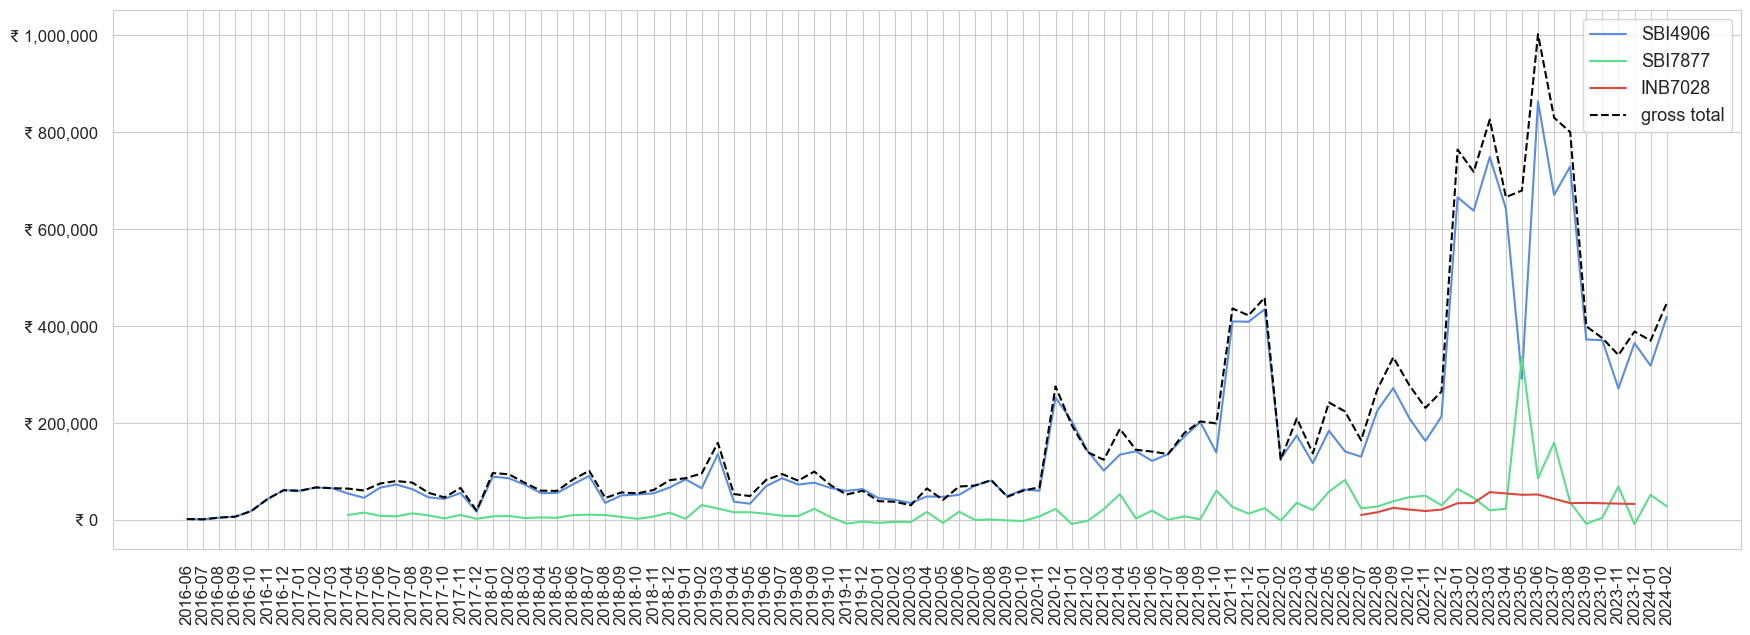

In [49]:
plt.plot(SBI4906["trx_month"].values, SBI4906["balance"].values, color = "#5B8DDE", label = "SBI4906")
plt.plot(SBI7877["trx_month"].values, SBI7877["balance"].values, color = "#5BDE89", label = "SBI7877")
plt.plot(INB7028["trx_month"].values, INB7028["balance"].values, color = "#DB483D", label = "INB7028")

plt.plot(tot["trx_month"].values, tot["balanace"].values, "k--", label = "gross total")

plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('₹ {x:,.0f}'))

plt.xticks(rotation = 90)
plt.legend()

In [47]:
# statement = """
# SELECT
#     A.account_id
#     , B.account_number
#     , B.account_name
#     , trx_date
#     , trx_type
#     , SUM( CASE WHEN trx_type = 'DEPOSIT' THEN trx_amount WHEN trx_type = 'WITHDRAW' THEN -trx_amount ELSE 0 END ) AS trx_amount
#     , CASE WHEN _trx_method IS NULL THEN "others" ELSE _trx_method END AS _trx_method
#     , _trx_account
#     , CASE WHEN _trx_pri_category IS NULL THEN "others" ELSE _trx_pri_category END AS _trx_pri_category
#     , CASE WHEN _trx_sec_category IS NULL THEN "others" ELSE _trx_sec_category END AS _trx_sec_category
# FROM "ams.DBTTransactions" A
# LEFT JOIN "ams.mwAccountProperty" B ON A.account_id = B.account_id
# WHERE B.account_name = '{account_name}'
# GROUP BY
#     A.account_id
#     , B.account_number
#     , B.account_name
#     , trx_date
#     , trx_type
#     , _trx_method
#     , _trx_account
#     , _trx_pri_category
#     , _trx_sec_category
# ORDER BY
#     trx_date, B.account_name
# """

vwDBTTransactions = pd.read_sql(statement.format(account_name = "SBI Baroda Park Branch"), con)

# # convert to datetime object, for handling
# vwDBTTransactions["trx_date"] = pd.to_datetime(vwDBTTransactions["trx_date"], format = "%Y-%m-%d") \
#     .apply(lambda x : x.date())

# # convert to monthly values, and get balance at a month level:
# vwDBTTransactions["trx_month"]

# get the day end balance, with iterative cummulative sum
vwDBTTransactions["balance"] = np.cumsum(vwDBTTransactions["trx_amount"].values)

vwDBTTransactions.sample(3)

,trx_month,trx_amount,balance
72,2022-06,"-42,716.200","141,130.510"
5,2016-11,"24,615.000","43,094.500"
82,2023-04,"-105,728.420","642,277.920"


In [48]:
vwDBTTransactions

,trx_month,trx_amount,balance
0,2016-06,"1,804.000","1,804.000"
1,2016-07,-600.000,"1,204.000"
2,2016-08,"3,562.000","4,766.000"
3,2016-09,"1,988.000","6,754.000"
4,2016-10,"11,725.500","18,479.500"
...,...,...,...
88,2023-10,"-1,500.000","370,437.000"
89,2023-11,"-99,477.000","270,960.000"
90,2023-12,"93,471.000","364,431.000"
91,2024-01,"-46,446.000","317,985.000"


C:\Users\debmalya\AppData\Local\Temp\ipykernel_23780\2710252398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SBI4906["balance"] = SBI4906["trx_amount"] - SBI4906["trx_amount"].shift(1)


<AxesSubplot:xlabel='trx_date', ylabel='trx_amount'>

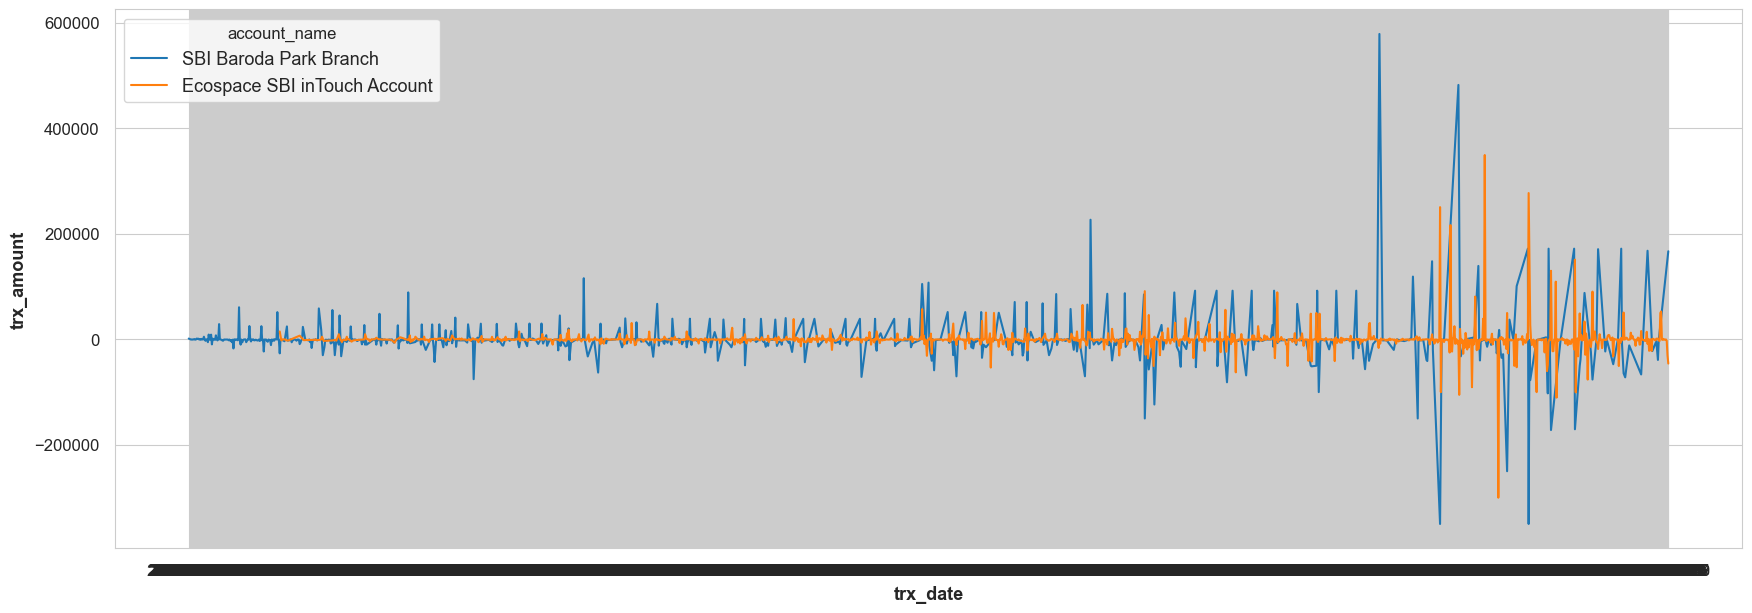

In [13]:
monthOverview = vwDBTTransactions.copy() # enable deepcopy

grouped = vwDBTTransactions.groupby(["trx_date", "account_name"])["trx_amount"].sum().reset_index()

sns.lineplot(x = "trx_date", y = "trx_amount", hue = "account_name", data = grouped)